## ****Image Segmentation on Oxford_iiit_pet dataset****
- Author : Rahul Golder

### ****Importing Libraries****

In [1]:
# @title Importing primary Libraries
import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime


In [2]:
# @title ****Mounting Drive****
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
# @title Importing tensorflow latest version and Keras
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import Input


2.8.0


In [4]:
# @title Importing Specific functions and layers from keras API

from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, Dropout, concatenate, Reshape
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger, ReduceLROnPlateau


### ****GPU Configuration**** (In case Running on GPU)

In [5]:
# @title GPU Configuration
os.environ["TF_MIN_GPU_MULTIPROCESSOR_COUNT"] = "4"

strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


### ****TPU Configuration**** (In case Running on TPU)

In [6]:
# @title TPU Initialization and Configuration 
# try:
#   tpu_address = "grpc://" + os.environ['COLAB_TPU_ADDR']
#   TPU = tf.distribute.cluster_resolver.TPUClusterResolver(tpu = '')
#   tf.config.experimental_connect_to_cluster(TPU)
#   tf.tpu.experimental.initialize_tpu_system(TPU)
#   strategy = tf.distribute.experimental.TPUStrategy(TPU)
#   print('Running on TPU ', TPU.cluster_spec().as_dict()['worker'])
#   print("Number of accelerators: ", strategy.num_replicas_in_sync)
#   print("TPU Running!!")
# except:
#   print("TPU Failed to Initialize!!")


#### Running a demo on TPU

In [7]:
# # Running on a specific TPU accelerator
# a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
# b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

# with tf.device('/TPU:0'):
#   c = tf.matmul(a, b)

# print("c device: ", c.device)
# print(c)


#### Creating Graph mode run using `tf.function` API

In [8]:
# @tf.function
# def matrix_mul(x, y):
#   z = tf.matmul(x, y)
#   return z

# z = strategy.run(matrix_mul, args = (a, b))
# print(z)

### ****Dataset Processing and Utilities****

In [9]:
# @title Loading the dataset
def load_dataset():
  !python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0

  dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

  print(dataset.keys())
  print("______________________INFO______________________________")
  print(info)

  return dataset, info

In [10]:
# @title Utilities Function 
def random_flip(input_image, input_mask):
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return input_image, input_mask


def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = random_flip(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)
  
  return input_image, input_mask


def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [11]:
# @title Preprocessing function 
def get_train_test(dataset):
  train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  test = dataset['test'].map(load_image_test) 
  return train, test

def preprocess_dataset(train, test):
  BATCH_SIZE = 64
  BUFFER_SIZE = 1000

  train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

  train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  test_dataset = test.batch(BATCH_SIZE)
  return train_dataset, test_dataset



In [12]:
dataset, info = load_dataset()
train, test = get_train_test(dataset)
train_df, test_df = preprocess_dataset(train, test)


I0506 10:40:40.129818 140082288293760 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
oxford_iiit_pet:3.1.0
Traceback (most recent call last):
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_datasets/scripts/download_and_prepare.py", line 242, in <module>
    app.run(main)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 312, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 258, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_datasets/scripts/download_and_prepare.py", line 203, in main
    for name in datasets_to_build
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_datasets/scripts/download_and_prepare.py", line 203, in <dictcomp>
    for name i

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteVDSPUZ/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteVDSPUZ/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
dict_keys(['test', 'train'])
______________________INFO______________________________
tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349

### ****Dataset Visualization and Utilities****

In [13]:
# @title Visualization Functions
class_names = ['pet', 'background', 'outline']

def display_with_metrics(display_list, iou_list, dice_score_list):  
  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list)

  display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string) 



def display(display_list,titles=[], display_string=None):
  plt.figure(figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)
  
  plt.show()



def show_image_from_dataset(dataset, id = 1):
  for image, mask in dataset.take(id):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask], titles=["Image", "True Mask"])



def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
  plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)



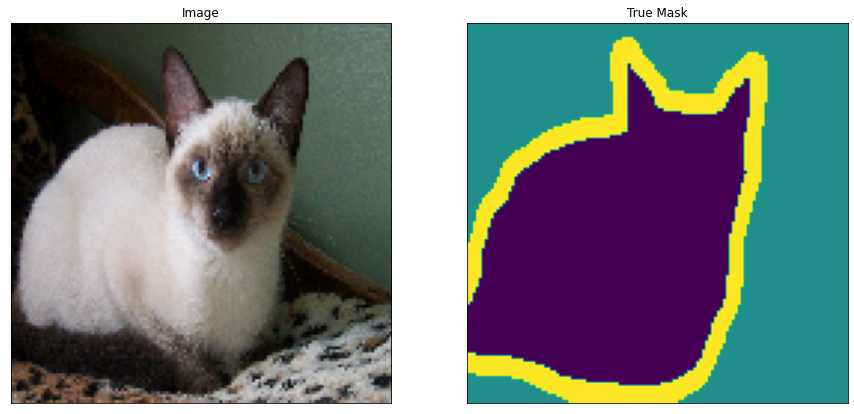

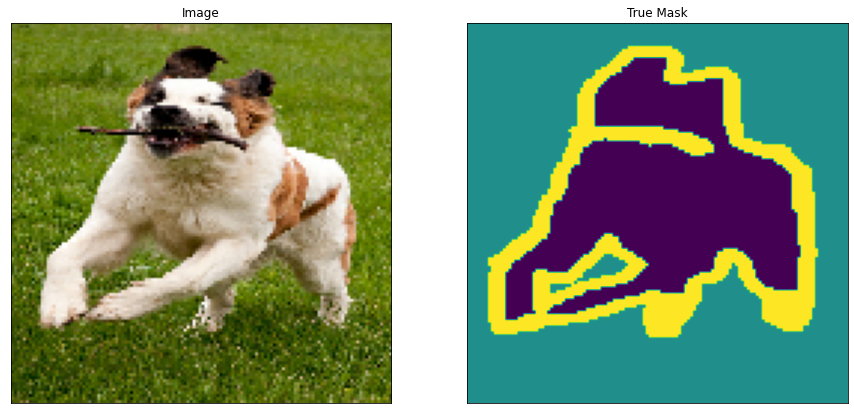

In [14]:
show_image_from_dataset(train, id = 4)
show_image_from_dataset(test, id = 3)

### ****Model****

In [15]:
# @title ****Model Overview****

<img src='https://drive.google.com/uc?export=view&id=1BeQSKL2Eq6Fw9iRXsN1hgunY-CS2nH7V' alt='unet'>

A UNet consists of an encoder (downsampler) and decoder (upsampler) with a bottleneck in between. The gray arrows correspond to the skip connections that concatenate encoder block outputs to each stage of the decoder. Let's see how to implement these starting with the encoder.

****Data Description****:

> ***Image Description:***

- Image size is `(128, 128, 3)` where `3` is the number of channels(RGB) in the image.

> ***Label Description:***

- Here we are labeling the image pixel by pixel according the classes in the images.
- The classes are `['pet', 'background', 'outline']` labeled as `[0, 1, 2]` .

> ***Training Dataset and Testing Dataset Description:***

- The Training Dataset is shuffled and divided in `32` bathces. The test dataset is also divided in `32` batches.
- Train dataset contains total of `3680` and Test dataset contains total of `3669` images.


****Model Description****:

<img src='https://drive.google.com/uc?export=view&id=1Gs9K3_8ZBn2_ntOtJL_-_ww4ZOgfyhrS' alt='unet'>

> ***Encoder:***
- 5 layers in the Encoder
- Layer-1 :
  - Tensor Shape = `(128, 128, 3)`
  - Layers - `Conv2D(64, 3, 'relu', 'same')*2` and `MaxPool2D(2)`
- Layer-2 :
  - Tensor Shape = `(64, 64, 64)`
  - Layers - `Conv2D(128, 3, 'relu', 'same')*2` and `MaxPool2D(2)`
- Layer-3 :
  - Tensor Shape = `(32, 32, 128)`
  - Layers - `Conv2D(216, 3, 'relu', 'same')*2` and `MaxPool2D(2)`
- Layer-4 :
  - Tensor Shape = `(16, 16, 256)`
  - Layers - `Conv2D(512, 3, 'relu', 'same')*2` and `MaxPool2D(2)`
- Layer-5 :
  - Tensor Shape = `(8, 8, 512)`


> ***Bottle Neck Layer***:
- Layer-1:
  - Tensor Shape = `(8, 8, 512)`
  - Layers = `Conv2D(1024, 3, 'relu', 'same')`


<img src='https://drive.google.com/uc?export=view&id=1Ql5vdw6l88vxaHgk7VjcMc4vfyoWYx2w' alt='unet_decoder'>

> ***Decoder***:
- Layer-1:
  - Tensor Shape = `(8, 8, 1024)`
  -  Layers = `Conv2DTranspose(512, 3, stride = 2)`->`Concatenation`-> `Conv2D(512, 3, 'relu', 'same')*2`
- Layer-2:
  - Tensor Shape = `(16, 16, 512)`
  -Layers = `Conv2DTranspose(256, 3, stride = 2)`->`Concatenation`-> `Conv2D(256, 3, 'relu', 'same')*2`
- Layer-3:
  - Tensor Shape = `(32, 32, 256)`
  -Layers = `Conv2DTranspose(128, 3, stride = 2)`->`Concatenation`-> `Conv2D(128, 3, 'relu', 'same')*2`
- Layer-4:
  - Tensor Shape = `(64, 64, 128)`
  -Layers = `Conv2DTranspose(64, 3, stride = 2)`->`Concatenation`-> `Conv2D(64, 3, 'relu', 'same')*2`
- Layer-5:
  - Tensor Shape = `(128, 128, 64)`
  -Layers = `Conv2DTranspose(64, 3, stride = 2)`->`Concatenation`-> `Conv2D(64, 3, 'relu', 'same')*2`->`Conv2D(11, 3, 'relu', 'same')`
- Final Shape = `(128, 128, 11)`

In [52]:
# @title ****Encoder****
def encoder_block_layers(input, filters, kernel_size = (3, 3), initializer = 'he_normal'):
  x = input
  for _ in range(2):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding= 'same', kernel_initializer = initializer)(x)
    x = Activation('relu')(x)

  return x



def encoder_block(inputs, filters, pool_size = (2, 2), dropout_rate = 0.3):
  x = inputs
  x = encoder_block_layers(x, filters = filters)
  appended = x
  x = MaxPool2D()(x)
  x = Dropout(rate = dropout_rate)(x)
  encoded = x
  return appended, encoded



def encoder(inputs):
  x = inputs
  f1, x = encoder_block(x, filters = 64)
  f2, x = encoder_block(x, filters = 128)
  f3, x = encoder_block(x, filters = 256)
  f4, x = encoder_block(x, filters = 512)

  return (f1, f2, f3, f4), x



In [53]:
# @title ****Bottleneck****
def bottleneck_layers(inputs, filters, kernel_size = (3, 3), initializer = 'he_normal'):
  x = inputs
  for _ in range(2):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = 'same', kernel_initializer = initializer)(x)
    x = Activation('relu')(x)
  
  return x


def bottleneck_block(inputs, filters):
  x = inputs
  output = bottleneck_layers(x, filters = filters)
  return output




In [54]:
# @title ****Decoder****
def decoder_block_layers(inputs, filters, kernel_size = (3, 3), initializer = 'he_normal'):
  x = inputs
  for _ in range(2):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = 'same', kernel_initializer = initializer)(x)
    output = Activation('relu')(x)
  return output



def decoder_block(inputs, concat, filters, kernel_size = (3, 3), stride = (2, 2), dropout_rate = 0.3):
  conv = inputs
  conv = Conv2DTranspose(filters = filters, kernel_size = kernel_size, strides = stride, padding = 'same')(conv)
  x = concatenate([conv, concat])
  x = decoder_block_layers(x, filters = filters)
  output = Dropout(rate = dropout_rate)(x)
  
  return output



def decoder(inputs, concat, OUTPUT_CHANNELS = 3):
  x = inputs
  c1, c2, c3, c4 = concat
  x = decoder_block(x, c4, filters = 512)
  x = decoder_block(x, c3, filters = 256)
  x = decoder_block(x, c2, filters = 128)
  x = decoder_block(x, c1, filters = 64)

  output = Conv2D(filters = OUTPUT_CHANNELS, kernel_size = (1, 1), activation = 'softmax')(x)
  return output



In [55]:
# @title ****UNet Model****
def Unet(INPUT_SHAPE = [128, 128, 3]):
  inputs = Input(shape = INPUT_SHAPE)
  x = inputs
  concat, encoder_output = encoder(x)
  bottleneck_output = bottleneck_block(encoder_output, filters = 1024)
  decoder_output = decoder(bottleneck_output, concat)

  unet_model = Model(inputs = inputs, outputs = decoder_output)

  return unet_model


In [56]:
# @title ****Model Creation****

model = Unet()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_39 (Conv2D)             (None, 128, 128, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 activation_38 (Activation)     (None, 128, 128, 64  0           ['conv2d_39[0][0]']              
                                )                                                           

In [21]:
# @title **Setting Current Working Directory**

os.chdir("/content/drive/MyDrive/Educational Workspace/DL_Workspace/Projects/pet_segmentor/")
os.getcwd()

'/content/drive/MyDrive/Educational Workspace/DL_Workspace/Projects/pet_segmentor'

In [22]:
# @title **Callbacks Utilities**
!rm -rf logs

logdir = os.path.join("/content/drive/MyDrive/Educational Workspace/DL_Workspace/TFS/Projects/pet_segmentor/logs", datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = TensorBoard(log_dir=logdir)

checkpoint = ModelCheckpoint('saved_model', save_best_only = True, verbose = 1)

csvlogger = CSVLogger('train.csv')

def reducelr(epoch):
  learning_rate = 0.001
  drop = 0.975
  epochs_drop = 1
  learning_rate = learning_rate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return learning_rate

learning_decay = LearningRateScheduler(reducelr, verbose = 1)

reducelr_plateau = ReduceLROnPlateau(factor = 0.1, patience = 4, verbose = 1)


In [23]:
# @title ****Model Compiling****
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss = 'sparse_categorical_crossentropy'
metrics = ['accuracy']

model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

In [24]:
# @title ****Model Run****

BATCH_SIZE = 64
TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 32
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_df, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_df,
                          callbacks = [checkpoint, tensorboard_callback, csvlogger])

Epoch 1/32
57/57 [==============================] - ETA: 0s - loss: 0.8967 - accuracy: 0.5798
Epoch 1: val_loss improved from inf to 0.81172, saving model to saved_model
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


57/57 [==============================] - 148s 2s/step - loss: 0.8967 - accuracy: 0.5798 - val_loss: 0.8117 - val_accuracy: 0.5815
Epoch 2/32
57/57 [==============================] - ETA: 0s - loss: 0.7392 - accuracy: 0.6804
Epoch 2: val_loss improved from 0.81172 to 0.66474, saving model to saved_model
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


57/57 [==============================] - 126s 2s/step - loss: 0.7392 - accuracy: 0.6804 - val_loss: 0.6647 - val_accuracy: 0.7315
Epoch 3/32
57/57 [==============================] - ETA: 0s - loss: 0.6375 - accuracy: 0.7456
Epoch 3: val_loss improved from 0.66474 to 0.59729, saving model to saved_model
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


57/57 [==============================] - 113s 2s/step - loss: 0.6375 - accuracy: 0.7456 - val_loss: 0.5973 - val_accuracy: 0.7609
Epoch 4/32
57/57 [==============================] - ETA: 0s - loss: 0.5954 - accuracy: 0.7660
Epoch 4: val_loss improved from 0.59729 to 0.54589, saving model to saved_model
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


57/57 [==============================] - 116s 2s/step - loss: 0.5954 - accuracy: 0.7660 - val_loss: 0.5459 - val_accuracy: 0.7828
Epoch 5/32
57/57 [==============================] - ETA: 0s - loss: 0.5274 - accuracy: 0.7961
Epoch 5: val_loss improved from 0.54589 to 0.49298, saving model to saved_model
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


57/57 [==============================] - 114s 2s/step - loss: 0.5274 - accuracy: 0.7961 - val_loss: 0.4930 - val_accuracy: 0.8112
Epoch 6/32
57/57 [==============================] - ETA: 0s - loss: 0.4892 - accuracy: 0.8120
Epoch 6: val_loss improved from 0.49298 to 0.48796, saving model to saved_model
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


57/57 [==============================] - 113s 2s/step - loss: 0.4892 - accuracy: 0.8120 - val_loss: 0.4880 - val_accuracy: 0.8124
Epoch 7/32
57/57 [==============================] - ETA: 0s - loss: 0.4541 - accuracy: 0.8279
Epoch 7: val_loss improved from 0.48796 to 0.43037, saving model to saved_model
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


57/57 [==============================] - 113s 2s/step - loss: 0.4541 - accuracy: 0.8279 - val_loss: 0.4304 - val_accuracy: 0.8340
Epoch 8/32
57/57 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.8367
Epoch 8: val_loss improved from 0.43037 to 0.40541, saving model to saved_model
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


57/57 [==============================] - 113s 2s/step - loss: 0.4268 - accuracy: 0.8367 - val_loss: 0.4054 - val_accuracy: 0.8426
Epoch 9/32
57/57 [==============================] - ETA: 0s - loss: 0.4036 - accuracy: 0.8473
Epoch 9: val_loss improved from 0.40541 to 0.38838, saving model to saved_model
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


57/57 [==============================] - 114s 2s/step - loss: 0.4036 - accuracy: 0.8473 - val_loss: 0.3884 - val_accuracy: 0.8560
Epoch 10/32
57/57 [==============================] - ETA: 0s - loss: 0.3859 - accuracy: 0.8542
Epoch 10: val_loss did not improve from 0.38838
57/57 [==============================] - 105s 2s/step - loss: 0.3859 - accuracy: 0.8542 - val_loss: 0.3960 - val_accuracy: 0.8442
Epoch 11/32
57/57 [==============================] - ETA: 0s - loss: 0.3732 - accuracy: 0.8580
Epoch 11: val_loss improved from 0.38838 to 0.38320, saving model to saved_model
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


57/57 [==============================] - 113s 2s/step - loss: 0.3732 - accuracy: 0.8580 - val_loss: 0.3832 - val_accuracy: 0.8546
Epoch 12/32
57/57 [==============================] - ETA: 0s - loss: 0.3671 - accuracy: 0.8614
Epoch 12: val_loss improved from 0.38320 to 0.36682, saving model to saved_model
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


57/57 [==============================] - 113s 2s/step - loss: 0.3671 - accuracy: 0.8614 - val_loss: 0.3668 - val_accuracy: 0.8599
Epoch 13/32
57/57 [==============================] - ETA: 0s - loss: 0.3478 - accuracy: 0.8676
Epoch 13: val_loss improved from 0.36682 to 0.35095, saving model to saved_model
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


57/57 [==============================] - 117s 2s/step - loss: 0.3478 - accuracy: 0.8676 - val_loss: 0.3510 - val_accuracy: 0.8673
Epoch 14/32
57/57 [==============================] - ETA: 0s - loss: 0.3584 - accuracy: 0.8649
Epoch 14: val_loss improved from 0.35095 to 0.34450, saving model to saved_model
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


57/57 [==============================] - 117s 2s/step - loss: 0.3584 - accuracy: 0.8649 - val_loss: 0.3445 - val_accuracy: 0.8713
Epoch 15/32
57/57 [==============================] - ETA: 0s - loss: 0.3225 - accuracy: 0.8775
Epoch 15: val_loss improved from 0.34450 to 0.33480, saving model to saved_model
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


57/57 [==============================] - 113s 2s/step - loss: 0.3225 - accuracy: 0.8775 - val_loss: 0.3348 - val_accuracy: 0.8728
Epoch 16/32
57/57 [==============================] - ETA: 0s - loss: 0.3170 - accuracy: 0.8803
Epoch 16: val_loss did not improve from 0.33480
57/57 [==============================] - 109s 2s/step - loss: 0.3170 - accuracy: 0.8803 - val_loss: 0.3409 - val_accuracy: 0.8726
Epoch 17/32
57/57 [==============================] - ETA: 0s - loss: 0.3032 - accuracy: 0.8838
Epoch 17: val_loss did not improve from 0.33480
57/57 [==============================] - 109s 2s/step - loss: 0.3032 - accuracy: 0.8838 - val_loss: 0.3477 - val_accuracy: 0.8698
Epoch 18/32
57/57 [==============================] - ETA: 0s - loss: 0.2999 - accuracy: 0.8863
Epoch 18: val_loss did not improve from 0.33480
57/57 [==============================] - 105s 2s/step - loss: 0.2999 - accuracy: 0.8863 - val_loss: 0.3402 - val_accuracy: 0.8750
Epoch 19/32
57/57 [==============================] 

INFO:tensorflow:Assets written to: saved_model/assets


57/57 [==============================] - 113s 2s/step - loss: 0.2986 - accuracy: 0.8862 - val_loss: 0.3339 - val_accuracy: 0.8774
Epoch 20/32
57/57 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.8902
Epoch 20: val_loss improved from 0.33389 to 0.33132, saving model to saved_model
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


57/57 [==============================] - 113s 2s/step - loss: 0.2874 - accuracy: 0.8902 - val_loss: 0.3313 - val_accuracy: 0.8778
Epoch 21/32
57/57 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.8946
Epoch 21: val_loss did not improve from 0.33132
57/57 [==============================] - 106s 2s/step - loss: 0.2741 - accuracy: 0.8946 - val_loss: 0.3404 - val_accuracy: 0.8794
Epoch 22/32
57/57 [==============================] - ETA: 0s - loss: 0.2696 - accuracy: 0.8971
Epoch 22: val_loss did not improve from 0.33132
57/57 [==============================] - 105s 2s/step - loss: 0.2696 - accuracy: 0.8971 - val_loss: 0.3501 - val_accuracy: 0.8790
Epoch 23/32
57/57 [==============================] - ETA: 0s - loss: 0.2646 - accuracy: 0.8982
Epoch 23: val_loss did not improve from 0.33132
57/57 [==============================] - 105s 2s/step - loss: 0.2646 - accuracy: 0.8982 - val_loss: 0.3348 - val_accuracy: 0.8805
Epoch 24/32
57/57 [==============================] 

INFO:tensorflow:Assets written to: saved_model/assets


57/57 [==============================] - 117s 2s/step - loss: 0.2378 - accuracy: 0.9080 - val_loss: 0.3289 - val_accuracy: 0.8802
Epoch 29/32
57/57 [==============================] - ETA: 0s - loss: 0.2346 - accuracy: 0.9092
Epoch 29: val_loss did not improve from 0.32887
57/57 [==============================] - 106s 2s/step - loss: 0.2346 - accuracy: 0.9092 - val_loss: 0.3478 - val_accuracy: 0.8830
Epoch 30/32
57/57 [==============================] - ETA: 0s - loss: 0.2345 - accuracy: 0.9095
Epoch 30: val_loss did not improve from 0.32887
57/57 [==============================] - 106s 2s/step - loss: 0.2345 - accuracy: 0.9095 - val_loss: 0.3394 - val_accuracy: 0.8814
Epoch 31/32
57/57 [==============================] - ETA: 0s - loss: 0.2318 - accuracy: 0.9099
Epoch 31: val_loss improved from 0.32887 to 0.32016, saving model to saved_model
INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


57/57 [==============================] - 113s 2s/step - loss: 0.2318 - accuracy: 0.9099 - val_loss: 0.3202 - val_accuracy: 0.8864
Epoch 32/32
57/57 [==============================] - ETA: 0s - loss: 0.2150 - accuracy: 0.9157
Epoch 32: val_loss did not improve from 0.32016
57/57 [==============================] - 106s 2s/step - loss: 0.2150 - accuracy: 0.9157 - val_loss: 0.3550 - val_accuracy: 0.8833


### ****Model Prediction****

#### ****Prediction Utilities****

In [25]:
# @title ****Prediction Functions****
def get_test_image_and_annotation_arrays(test_dataset = test_df):
  ds = test_dataset.unbatch()
  ds = ds.batch(info.splits['test'].num_examples)
  
  images = []
  y_true_segments = []

  for image, annotation in ds.take(1):
    y_true_segments = annotation.numpy()
    images = image.numpy()
  
  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
  
  return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments


def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(image, mask, num=1):
  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask 

In [26]:
# @title ****Metrics Function****

def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001
  for i in range(3):
    
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

In [27]:
# @title ****Result Function****

def show_results(integer_slider, test_df = test_df, info = info, BATCH_SIZE = BATCH_SIZE):
  y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

  results = model.predict(test_df, steps=info.splits['test'].num_examples//BATCH_SIZE)
  results = np.argmax(results, axis=3)
  results = results[..., tf.newaxis]

  cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

  print("__________________________________Class Wise Metrics________________________")

  for idx, iou in enumerate(cls_wise_iou):
    spaces = ' ' * (10-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, iou)) 

  for idx, dice_score in enumerate(cls_wise_dice_score):
    spaces = ' ' * (10-len(class_names[idx]) + 2)
    print("{}{}{} ".format(class_names[idx], spaces, dice_score)) 

  y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])

  iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)

  print("__________________________Results for Given Image__________________")  

  display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)


#### ****Model Results****

__________________________________Class Wise Metrics________________________
pet         0.7817889033486072 
background  0.87812828048086 
outline     0.4653502864281103 
pet         0.8775325762547496 
background  0.9351100130989556 
outline     0.6351386296348107 
__________________________Results for Given Image__________________


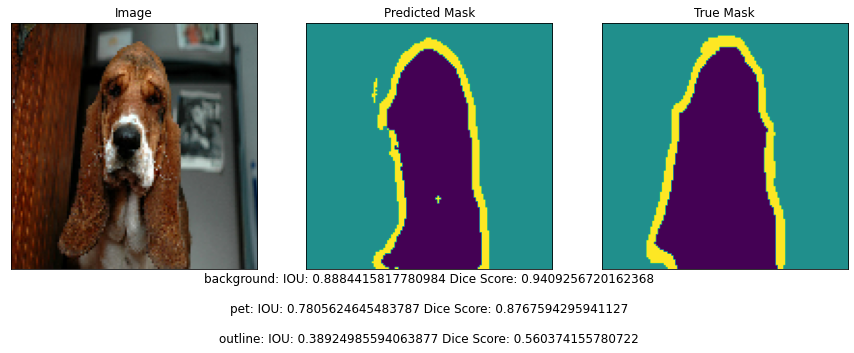

In [28]:
# Please input a number between 0 to 3647 to pick an image from the dataset
integer_slider = 2485
show_results(integer_slider)

## ****Pet Image Segmentor****

In [ ]:
# @title **Tensorboard Observation**
%load_ext tensorboard
%tensorboard --logdir logs

__________________________________Class Wise Metrics________________________
pet         0.7817888767657665 
background  0.87812822571776 
outline     0.46535033819993116 
pet         0.8775325595084487 
background  0.935109982048532 
outline     0.6351386778562881 
__________________________Results for Given Image__________________


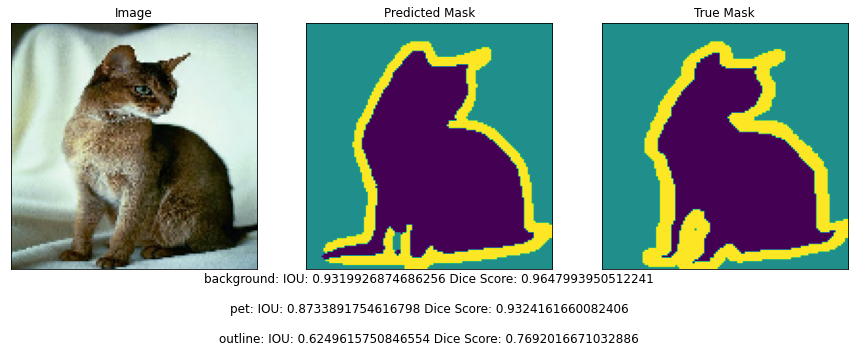

In [30]:
# @markdown Please input a number between 0 to 3647 to pick an image from the dataset
integer_slider = 987 # @param
show_results(integer_slider)

## **Model Saving**

In [31]:
# @title ****Getting the Current Datetime****
from datetime import datetime

now = datetime.now()
 
print("now =", now)

dt_string = now.strftime("%d%m%Y_%H%M%S")
print("date and time =", dt_string)	

now = 2022-05-06 12:08:23.573633
date and time = 06052022_120823


In [32]:
# @title ****Saving The Model****
title = "/content/drive/MyDrive/Educational Workspace/DL_Workspace/TFS/Projects/pet_segmentor/models/" + dt_string + ".h5"
print(title)
model.save(title)

/content/drive/MyDrive/Educational Workspace/DL_Workspace/TFS/Projects/pet_segmentor/models/06052022_120823.h5
